In [1]:
# Imports
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def generate_random_price_series(start_date='2023-01-01', periods=252, start_price=100, volatility=0.01):
    """
    Generate a random price series over a year.
    
    Parameters:
    - start_date (str): The start date for the series in 'YYYY-MM-DD' format.
    - periods (int): Number of trading days (default is 252, typical number of trading days in a year).
    - start_price (float): The initial price.
    - volatility (float): Daily volatility (standard deviation of daily returns).
    
    Returns:
    - pd.Series: A pandas Series with datetime index and random price values.
    """
    # Generate date range
    date_range = pd.date_range(start=start_date, periods=periods, freq='B')
    
    # Generate random returns
    returns = np.random.normal(loc=0, scale=volatility, size=periods)
    
    # Calculate price series
    prices = start_price * (1 + returns).cumprod()
    
    # Create and return the pandas Series
    return pd.Series(prices, index=date_range, name='Price')

#### 1. Sampling for reduction
What conditions should preceed the algorithms training data

In [3]:
# 1. CUMSUM filter - when a cumulative price movement has taken place
# 2. Tight volatility range - consolidation period leads to bigger move
def inverse_cumsum_filter(series: pd.Series, h: float, n: int) -> pd.Series:
    """
    Apply a cumulative sum filter to a time series based on a rolling period.
    
    Parameters:
    - series: pd.Series, time series of prices with time stamp index
    - h: float, threshold value for filtering
    - n: int, lookback period for the rolling window
    
    Returns:
    - pd.Series, boolean series where True indicates dates flagged by the filter
    """
    returns = series.pct_change()       
    # Ensure the series is sorted by index (time)
    returns = returns.add(1)
    
    # Calculate the rolling cumulative sum over the lookback period n
    rolling_cumsum = returns.rolling(window=n).apply(np.prod) -1
    
    # Flag dates where the cumulative return is less than the absolute value of h
    flagged = (rolling_cumsum.abs() < h)
    
    return flagged

def plot_with_flags(series: pd.Series, flagged: pd.Series):
    """
    Plots a time series and highlights flagged dates as red dots.
    
    Parameters:
    - series: pd.Series, the original time series of returns with timestamp index
    - flagged: pd.Series, boolean series indicating flagged dates
    """
    # Ensure the series is sorted by time index
    series = series.sort_index()

    # Plot the time series
    plt.figure(figsize=(10, 6))
    plt.plot(series.index, series.values, label='Time Series', color='blue')

    # Highlight flagged dates as red dots
    plt.scatter(series.index[flagged], series.values[flagged], color='red', label='Flagged Dates')

    # Add labels and legend
    plt.title(f"Time Series with Flagged Dates; Percent labels = {np.average(flagged)*100}%")
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.legend()

    # Display the plot
    plt.grid(True)
    plt.show()


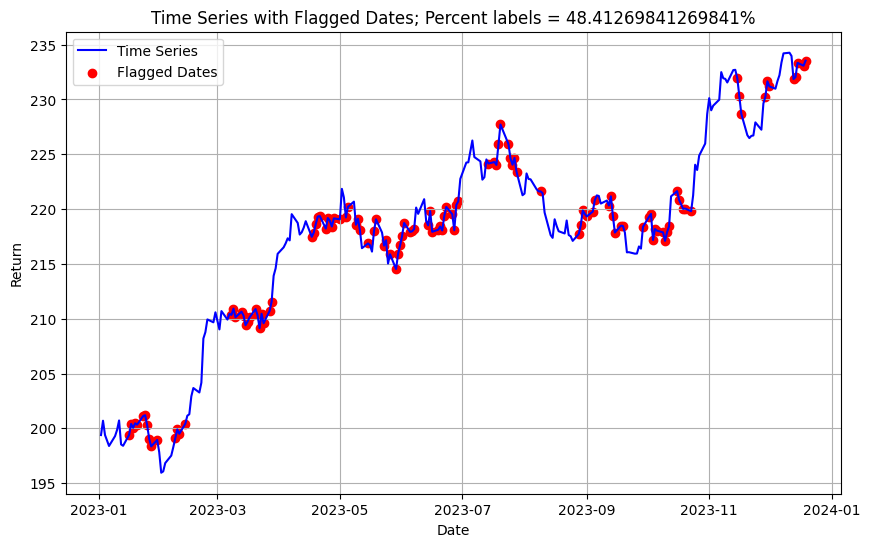

In [12]:
# Apply the cumsum_filter with a threshold h and a lookback period n
# close = generate_random_price_series()

h = 0.02
n = 10
flagged_dates = inverse_cumsum_filter(close, h, n)
# percent_labels = np.average(flagged_dates)*100

plot_with_flags(series = close+100, flagged = flagged_dates)

In [5]:
def generate_percent_label_matrix(samples: int = 100):
    """
    Generate a matrix of % label values for different combinations of h and n.
    
    h ranges from 0.01 to 0.2 with a step of 0.01.
    n ranges from 3 to 30 with a step of 1.
    The % label is based on an average of 100 random series.
    
    Returns:
    - pd.DataFrame, with rows as n values and columns as h values, containing % label values.
    """
    # Range of h values from 0.01 to 0.2 with step 0.01
    h_values = np.arange(0.01, 0.11, 0.01)
    # Range of n values from 3 to 30 with step 1
    n_values = np.arange(3, 31, 1)
    
    # Initialize an empty matrix to store % label values
    percent_label_matrix = np.zeros((len(n_values), len(h_values)))

    # Perform calculations
    for i, n in enumerate(n_values):
        for j, h in enumerate(h_values):
            # Average percent labels over 100 random series
            percent_labels = []
            for _ in range(samples):  # Generate 100 random series
                cumulative = generate_random_price_series()  # Generate random return series
                flagged_dates = inverse_cumsum_filter(cumulative, h, n)  # Apply filter
                percent_labels.append(np.average(flagged_dates) * 100)  # Calculate % flagged
            
            # Store the average % label in the matrix
            percent_label_matrix[i, j] = np.mean(percent_labels)
    
    # Convert the matrix into a DataFrame for better readability, with n as index and h as columns
    percent_label_df = pd.DataFrame(percent_label_matrix, index=n_values, columns=h_values)
    
    return percent_label_df

def plot_percent_label_matrix(matrix: pd.DataFrame, lower_threshold: float = 18, upper_threshold: float = 62):
    """
    Visualize the percent label matrix using a heatmap.
    
    Parameters:
    - matrix: pd.DataFrame, matrix of % label values where rows are n values and columns are h values
    """
    # Create a mask for values less than the threshold
    mask = (matrix < lower_threshold) | (matrix > upper_threshold)
    
    # Create the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(matrix, mask=mask, annot=True, cmap="YlGnBu", cbar_kws={'label': '% Label'}, 
                vmin=lower_threshold, linewidths=0.5, linecolor='gray')
    
    # Set the labels and title
    plt.title('Heatmap of % Label Values for Different n and h')
    plt.xlabel('h (Threshold)')
    plt.ylabel('n (Lookback Period)')
    
    # Show the plot
    plt.show()

In [6]:
# # Assuming percent_label_matrix is the output from generate_percent_label_matrix()
# percent_label_matrix = generate_percent_label_matrix(100)
# percent_label_matrix.to_csv('percent_label_matrix.csv', index=False)

In [259]:
percent_label_matrix = pd.read_csv('percent_label_matrix.csv')

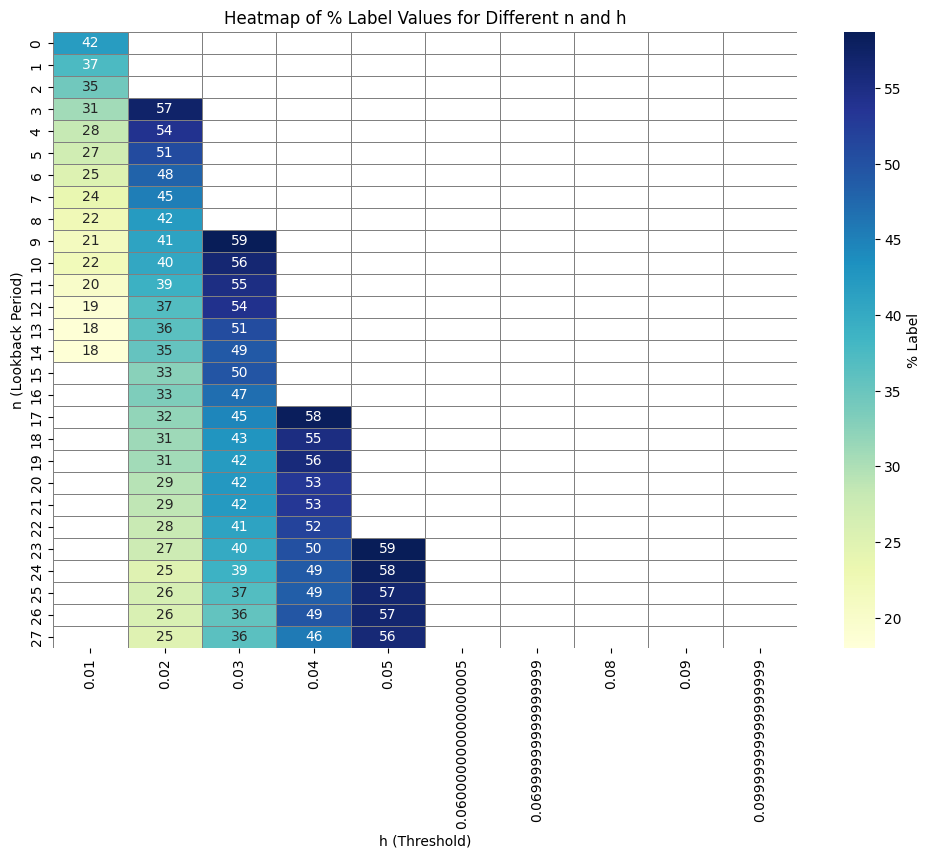

In [260]:
# Visualize the matrix
plot_percent_label_matrix(percent_label_matrix, upper_threshold=60)

#### 2. Triple barrier method

Vertical barrier: 3x-4x of inverse cumsum lookback period
Upper/lower barrier: 3x to 4x of inverse cumsum threshold

In [201]:
# Getting dates for the vertical barrier
def get_vertical_barrier(t_events, close, num_days=1):
    """Get a datetime index of dates for the vertical barrier

    Args:
        tEvents (datetime index): dates when the algorithm should look for trades
        close (pd.Series): series of prices
        numDays (int, optional): vertical barrier limit. Defaults to 1.

    Returns:
        pd.Series: series of datetime values
    """
    t1=close.index.searchsorted(t_events+pd.Timedelta(days=num_days))
    t1=t1[t1<close.shape[0]]
    t1=(pd.Series(close.index[t1],index=t_events[:t1.shape[0]]))
    return t1

In [236]:
def find_min_column(row):
    # Find the minimum value excluding 'vb' if it ties with another column
    # print(row['vb'])
    # print(row['sl'])
    # print(row['pt'])
    # print("+++")
    if pd.isnull(row['pt']) & pd.isnull(row['sl']):
        min_value = row[['pt', 'sl']].min()
    else:
        min_value = pd.Timestamp(0)
    return row[['pt', 'sl']].idxmin() if min_value <= row['vb'] else row[['pt', 'sl', 'vb']].idxmin()

In [229]:
pd.Timestamp(0)

Timestamp('1970-01-01 00:00:00')

In [234]:
def triple_barrier_method(close, t_events: pd.Series, pt_sl: int, n_days:int):
    trgt = pd.Series(0.01, index=t_events)

    v_bars = get_vertical_barrier(t_events, close, n_days)
    pt_sl = [pt_sl, -pt_sl]

    events = pd.concat({'vb':v_bars, 'trgt': trgt}, axis=1).dropna(subset=['trgt'])

    exits = events[['vb']].copy(deep=True)

    pt = pt_sl[0]*events['trgt']
    sl = pt_sl[1]*events['trgt']

    for event, vb in events['vb'].fillna(close.index[-1]).items():

        price_path = close[event:vb]
        return_path = (price_path/close[event]-1)
        exits.loc[event,'sl'] = return_path[return_path<sl[event]].index.min() # earliest stop loss
        exits.loc[event,'pt'] = return_path[return_path>pt[event]].index.min() # earliest profit taking

    
    exits['vb'] = exits['vb'].fillna(close.index[-1])
    exits['barrier_hit'] = exits.apply(find_min_column, axis=1)
    exits['hit_date'] = exits[['vb', 'sl', 'pt']].min(axis=1)
    exits['returns'] = close[exits['hit_date']].values/close[t_events].values -1
    exits['bin'] = np.sign(exits['returns'])
    exits.loc[exits['barrier_hit']=='vb', 'bin'] = 0

    return exits[['bin', 'returns', 'hit_date']]

In [113]:
# exits_ = exits.dropna(subset=['vb'])
# px = exits_.index.union(exits_['vb'].values).drop_duplicates()
# px = close.reindex(px, method='bfill')

# out = pd.DataFrame(index=exits_.index)
# out['ret'] = px.loc[exits_['vb'].values].values / px.loc[exits_.index] - 1
# out['bin'] = np.sign(px.loc[exits_['vb'].values].values / px.loc[exits_.index] - 1)

# vtouch_first_idx = exits[exits['vb'].isin(v_bars.values)].index
# out.loc[vtouch_first_idx, 'bin'] = 0.

In [245]:
def calculate_zero_bin_percentage(n_samples):
    # Initialize a matrix to store the results
    matrix = np.zeros((30, 10))
    n_values = range(1, 31)
    h_values = range(1, 11)

    # Loop through values of n (1 to 30) and h (1 to 10)
    for n in n_values:
        for h in h_values:
            zero_counts = []
            for _ in range(n_samples):
                # Call triple_barrier_method and get the DataFrame
                close = generate_random_price_series()
                t_events = inverse_cumsum_filter(close, 0.01, 5)
                t_events = t_events[t_events].index
                df = triple_barrier_method(close, t_events, h, n)
                # Calculate the percentage of bin values that are zero
                zero_percentage = (df['bin'] == 0).mean() * 100
                zero_counts.append(zero_percentage)
            # Store the average percentage in the matrix
            matrix[n-1, h-1] = np.mean(zero_counts)

    # Convert the matrix into a DataFrame for better readability, with n as index and h as columns
    percent_label_df = pd.DataFrame(matrix, index=n_values, columns=h_values)
    
    return percent_label_df

In [261]:
bin_dist = calculate_zero_bin_percentage(100)
bin_dist.to_csv('bin_dist.csv')

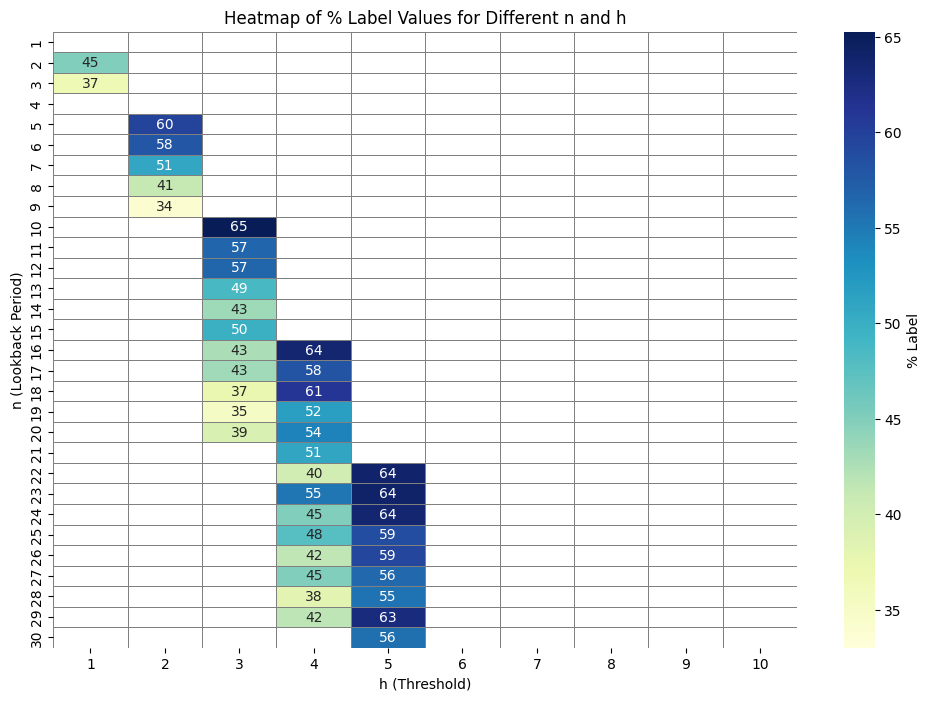

In [252]:
# Visualize the matrix
plot_percent_label_matrix(bin_dist, lower_threshold=33, upper_threshold=66)